In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
from shapely import wkt
import pickle
import json

/Users/berendmarkhorst/Library/Mobile Documents/com~apple~CloudDocs/PhD/READINESS/08 - Trondheim/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Convert Table 4 to Figure
I want to visualize at which facilities the different traders are active.

In [41]:
file = "Data/OurData2.xlsx"
nodes_df = pd.read_excel(file, sheet_name="Nodes", skiprows=1)
shipper_df = pd.read_excel(file, sheet_name="Traders")

# We include this to merge with the shipper df later
nodes_df["Name lowercase"] = nodes_df["Name"].str.lower()
nodes_df.set_index("Name lowercase", inplace = True)

In [5]:
trader_abbreviated_names = ["Shell", "Aker BP", "ConocoPhillips", "Equinor", "Lundin Energy", "Neptune Energy", "Var Energi", "Wintershall DEA"]

def get_short_name(trader):
    return [t for t in trader_abbreviated_names if t in trader][0]

In [43]:
nodes_geo_df = gpd.GeoDataFrame(nodes_df, geometry=nodes_df[["X_coordinate", "Y_coordinate"]].apply(Point, axis=1)).set_crs(4326).to_crs(32631)

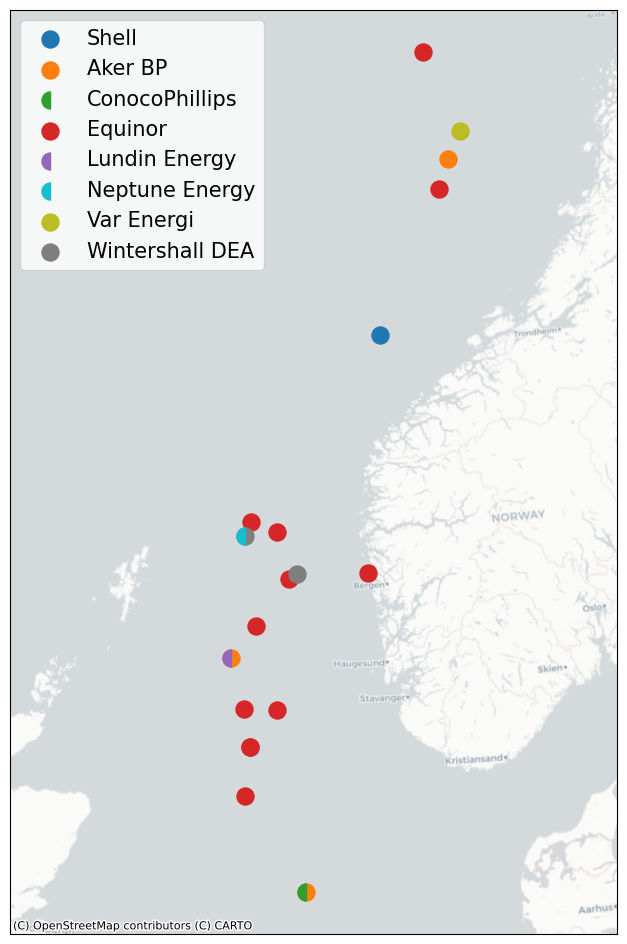

In [67]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
          "#9467bd", "#17becf", "#bcbd22", "#7f7f7f"]

traders = shipper_df.columns
trader_dict = {}
for i, trader in enumerate(traders):
    facilities_of_trader = shipper_df[trader].str.lower()[:12].dropna().values
    if trader in ["ConocoPhillips Skandinavia AS", "Lundin Energy Norway AS", "Neptune Energy Norge AS"]:
        marker = MarkerStyle("o", fillstyle="left")
        z = 100
    else:
        z = 1
        marker = MarkerStyle("o")

    short_name_trader = get_short_name(trader)
    nodes_geo_df.loc[facilities_of_trader].plot(figsize=(20,30), color=colors[i], ax=plt.gca(), marker=marker, label=short_name_trader, zorder = z, markersize=150)

plt.xlim(100000,950000)
plt.gcf().set_size_inches(12,12)
plt.legend(fontsize=15)
plt.xticks([])
plt.yticks([])
cx.add_basemap(ax=plt.gca(), crs=32631, source=cx.providers.CartoDB.Positron)

plt.savefig("Figures/traders.pdf", bbox_inches='tight')

plt.show()

# Visualize minimum contracts

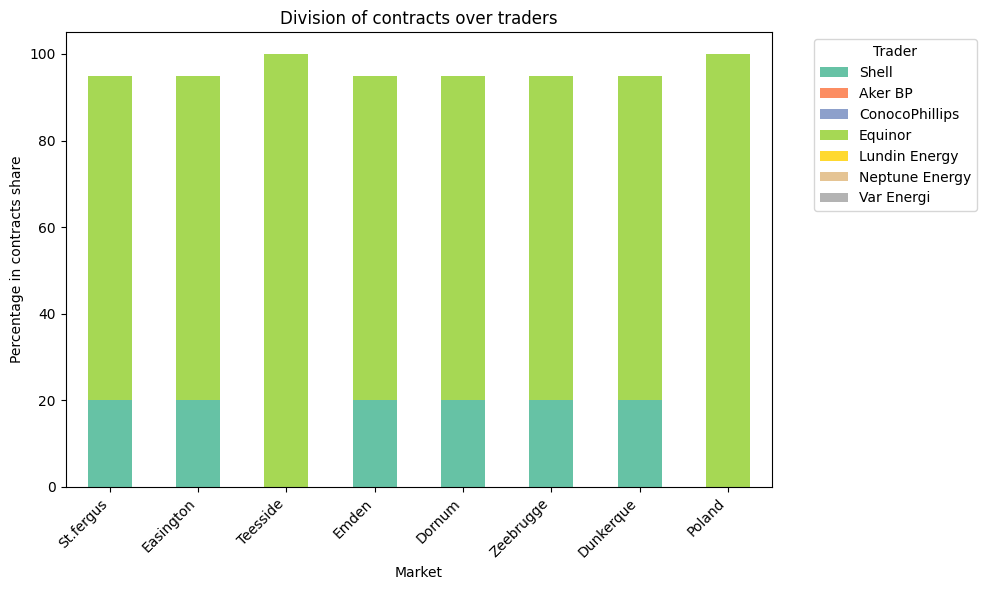

In [68]:
trader_percentages_df = pd.read_excel(file, sheet_name="TraderPercentages")

# Only select the relevent part of the dataframe
trader_percentages_df = trader_percentages_df.iloc[:7][trader_percentages_df.columns[:9]]
trader_percentages_df["Trader"] = trader_percentages_df["Trader"].apply(lambda x: get_short_name(x))
trader_percentages_df.set_index("Trader", inplace=True)
trader_percentages_df.columns = trader_percentages_df.columns.str.capitalize()
trader_percentages_df = trader_percentages_df * 100
trader_percentages_df = trader_percentages_df.T

# Plot stacked bar chart
trader_percentages_df.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set2")

# Labels and title
plt.xlabel("Market")
plt.ylabel("Percentage in contracts share")
plt.title("Division of contracts over traders")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.tight_layout()
plt.savefig("Figures/minimum_contracts.pdf", bbox_inches='tight')
plt.show()

# Visualize facilities and pipes

In [46]:
arcs_df = pd.read_excel(file, sheet_name="Arcs")
arcs_df["geometry"] = arcs_df["geometry"].apply(wkt.loads)
arcs_geo_df = gpd.GeoDataFrame(arcs_df, geometry="geometry").set_crs(4326).to_crs(32631)

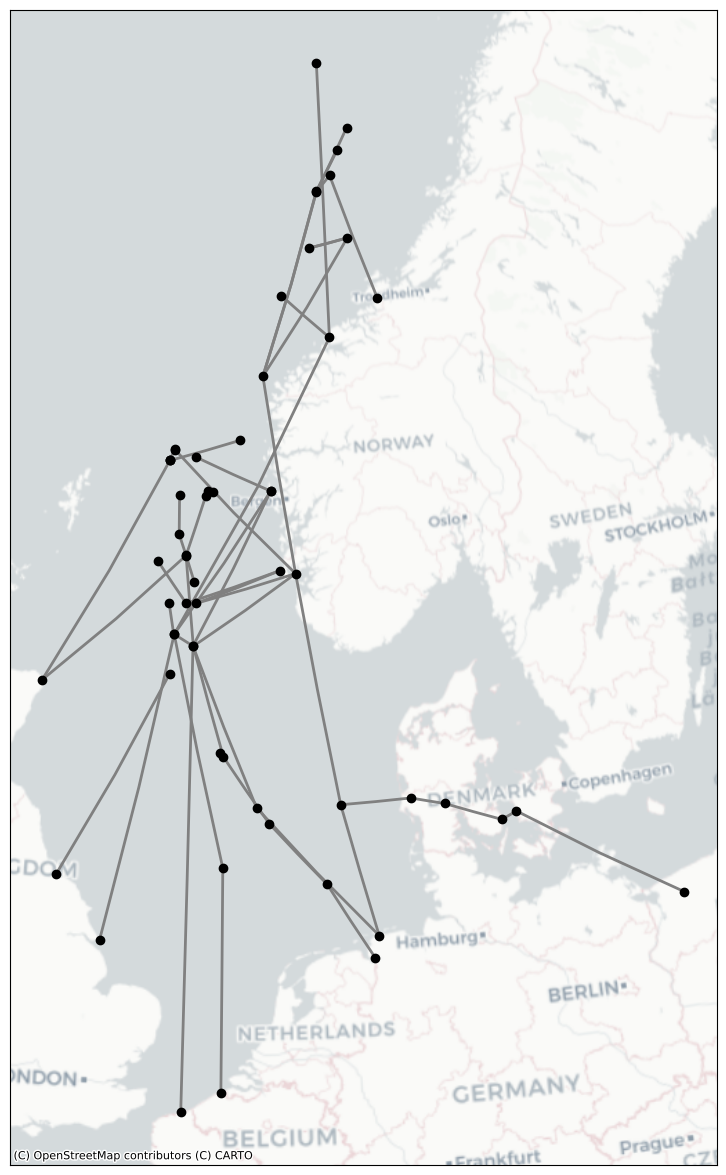

In [47]:
nodes_geo_df.plot(figsize=(10,15),zorder=2, color="black")
arcs_geo_df.plot(ax=plt.gca(), color='gray', linewidth=2, zorder=1)
cx.add_basemap(ax=plt.gca(), crs=32631, source=cx.providers.CartoDB.Positron)

plt.xticks([])
plt.yticks([])
plt.savefig("Figures/network.pdf", bbox_inches='tight')
plt.show()

# 4.3.1 Capacity booking in primary and secondary markets

In [2]:
def read_data(input_file):
    # Load the problem instance back from the file
    with open(f"{input_file}.pkl", "rb") as file:
        problem = pickle.load(file)

    # Read a dictionary from a json file
    with open(f"{input_file}.json", "r") as file:
        solution = json.load(file)

    return problem, solution

def get_value_from_solution(key, solution):
    return solution[key] if key in solution.keys() else 0

In [3]:
input_file = "Results/result_E_false_low_flow_costs_low_entry_costs"

problem, solution = read_data(input_file)

Show for second and third stage per scenario who sells and buys how much exit capacity.

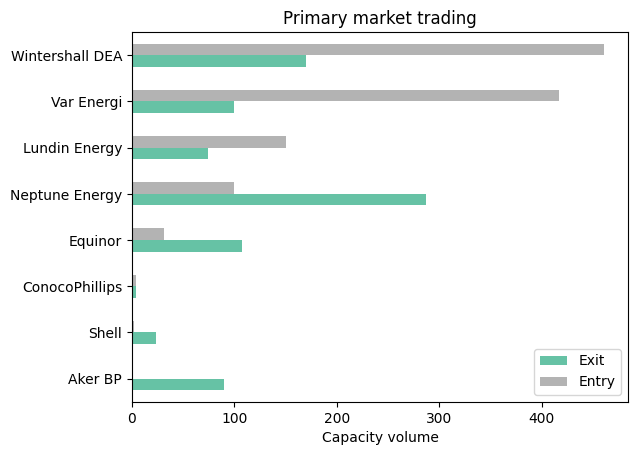

In [178]:
# Primary market
bought_primary_market_exit = {}
bought_primary_market_entry = {}
for m in problem.stages:
    if m.name == "long term" and m.hour == 4:
        for t in problem.traders:
            short_name = get_short_name(t.name)
            bought_primary_market_exit[short_name] = sum(m_tilde.probability * get_value_from_solution(f"x_minus[{n.node_id},{m_tilde.stage_id},{t.trader_id},{k.commodity_id}]", solution) for m_tilde in m.all_parents + [m] for n in m_tilde.nodes for k in problem.commodities)
            bought_primary_market_entry[short_name] = sum(m_tilde.probability * get_value_from_solution(f"x_plus[{n.node_id},{m_tilde.stage_id},{t.trader_id},{k.commodity_id}]", solution) for m_tilde in m.all_parents + [m] for n in m_tilde.nodes for k in problem.commodities)

df1 = pd.DataFrame({"Exit": bought_primary_market_exit})

df2 = pd.DataFrame({"Entry": bought_primary_market_entry})

df = pd.concat([df1, df2], axis=1)

df.sort_values("Entry").plot(kind="barh", cmap="Set2")

plt.xlabel("Capacity volume")

plt.title("Primary market trading");

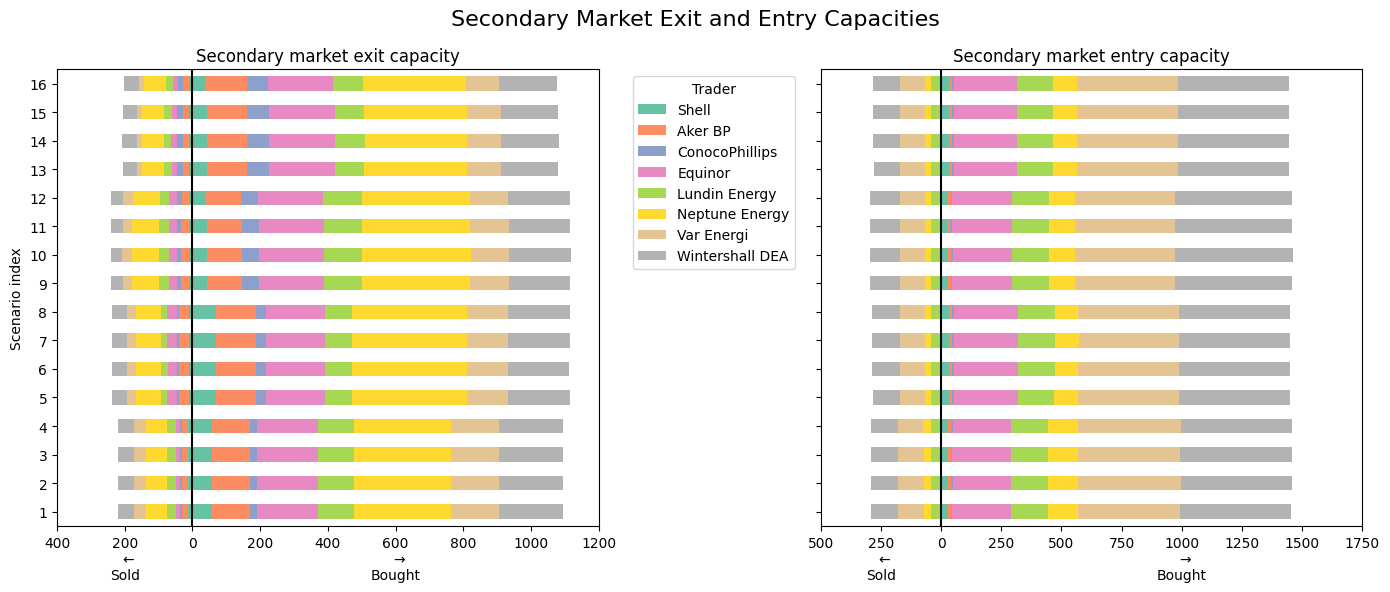

In [177]:
def plot_secondary_market(capacity_type, ax, show_legend=True):
    if capacity_type == "exit":
        dv_type = "minus"
    else:
        dv_type = "plus"
    
    # Secondary market
    sold, bought = {}, {}
    s = 0
    for m in problem.third_stages:
        if m.hour == 4:
            s += 1
            sold[s], bought[s] = {}, {}
            for t in problem.traders:
                short_name = get_short_name(t.name)
                sold[s][short_name] = -sum(m_tilde.probability * get_value_from_solution(f"y_{dv_type}[{n.node_id},{m_tilde.stage_id},{t.trader_id},{k.commodity_id}]", solution) for m_tilde in m.all_parents + [m] for n in m_tilde.nodes for k in problem.commodities if m_tilde != "long term")
                bought[s][short_name] = sum(m_tilde.probability * get_value_from_solution(f"x_{dv_type}[{n.node_id},{m_tilde.stage_id},{t.trader_id},{k.commodity_id}]", solution) for m_tilde in m.all_parents + [m] for n in m_tilde.nodes for k in problem.commodities if m_tilde != "long term")
    
    # Plot data
    pd.DataFrame(sold).T.plot(kind="barh", stacked=True, ax=ax, cmap="Set2")
    pd.DataFrame(bought).T.plot(kind="barh", stacked=True, ax=ax, cmap="Set2")
    
    ax.axvline(x=0, color="black")
    
    # Get legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    
    # Remove duplicates
    unique_labels = []
    unique_handles = []
    for h, l in zip(handles, labels):
        if l not in unique_labels:
            unique_labels.append(l)
            unique_handles.append(h)
    
    if show_legend:
        ax.legend(unique_handles, unique_labels, title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax.legend().set_visible(False)  # Hides the legend
    
    ax.set_title(f"Secondary market {capacity_type} capacity")
    
    # Get xtick positions and labels
    xticks = ax.get_xticks()
    xtick_labels = [f"{abs(tick):.0f}" for tick in xticks]
    
    # Add "Sold" and "Bought" once below the axis
    if any(tick < 0 for tick in xticks):
        negative_indices = [idx for idx, tick in enumerate(xticks) if tick <= 0]
        middle_idx = negative_indices[len(negative_indices) // 2]
        xtick_labels[middle_idx] += "\n " + r"$\leftarrow$" + "\n" + "Sold"
    if any(tick > 0 for tick in xticks):
        positive_indices = [idx for idx, tick in enumerate(xticks) if tick >= 0]
        middle_idx = positive_indices[len(positive_indices) // 2]
        xtick_labels[middle_idx] += "\n " + r"$\rightarrow$" + "\n" + "Bought"
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_ylabel("Scenario index")

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # Two subplots side by side

# Plot both scenarios (exit and entry) on different subplots
plot_secondary_market("exit", axes[0], show_legend=True)  # First plot (exit)
plot_secondary_market("entry", axes[1], show_legend=False)  # Second plot (entry), no legend

# Add a global title for the whole figure
fig.suptitle("Secondary Market Exit and Entry Capacities", fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


Let's zoom in on the results for one specific scenario!

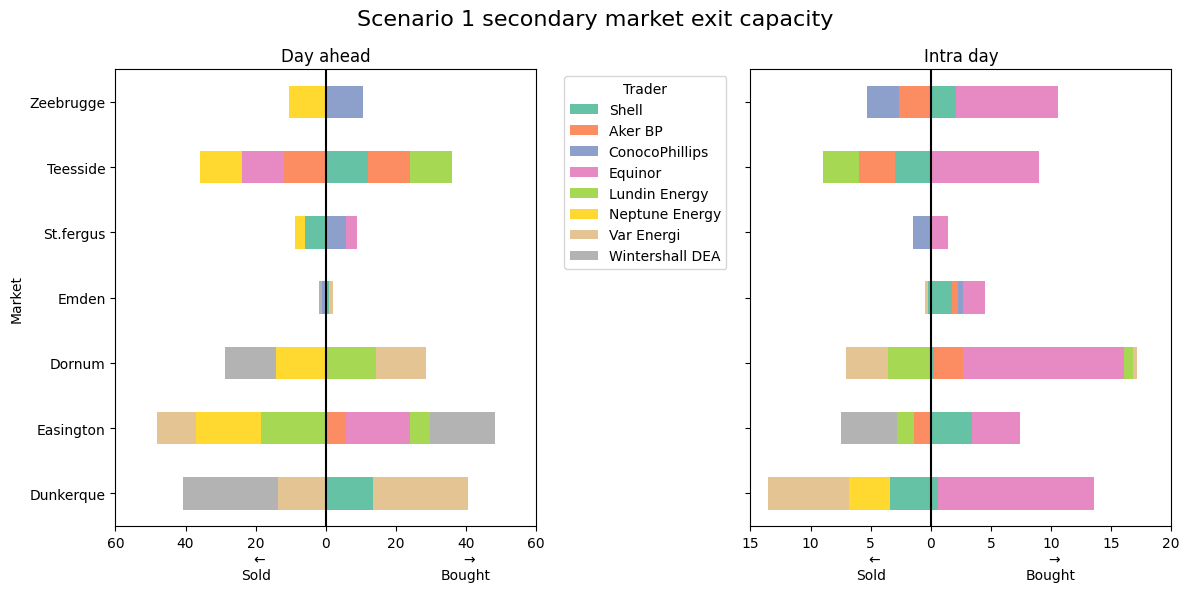

In [179]:
def plot_individual_scenario(ax, result_sold, result_bought, scenario_id, specific_name, show_legend):
    df1 = pd.DataFrame(result_sold[scenario_id])
    df2 = pd.DataFrame(result_bought[scenario_id])
    
    df1 = df1.loc[~(df1.eq(0).all(axis=1))]
    df2 = df2.loc[~(df2.eq(0).all(axis=1))]
    
    df1.plot(kind="barh", stacked=True, ax=ax, cmap="Set2")
    df2.plot(kind="barh", stacked=True, ax=ax, cmap="Set2")
    
    ax.axvline(x=0, color="black")
    
    # Get legend handles and labels (only for the first subplot)
    handles, labels = ax.get_legend_handles_labels()
    
    if show_legend:
        # Remove duplicates
        unique_labels = []
        unique_handles = []
        for h, l in zip(handles, labels):
            if l not in unique_labels:
                unique_labels.append(l)
                unique_handles.append(h)
        
        # Add legend only once
        ax.legend(unique_handles, unique_labels, title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax.legend().set_visible(False)  # Hide legend for second plot

    # Get xtick positions and labels
    xticks = ax.get_xticks()
    xtick_labels = [f"{abs(tick):.0f}" for tick in xticks]
    
    # Add "Sold" and "Bought" labels
    if any(tick < 0 for tick in xticks):
        negative_indices = [idx for idx, tick in enumerate(xticks) if tick <= 0]
        middle_idx = negative_indices[len(negative_indices) // 2]
        xtick_labels[middle_idx] += "\n " + r"$\leftarrow$" + "\n" + "Sold"
    if any(tick > 0 for tick in xticks):
        positive_indices = [idx for idx, tick in enumerate(xticks) if tick >= 0]
        middle_idx = positive_indices[len(positive_indices) // 2]
        xtick_labels[middle_idx] += "\n " + r"$\rightarrow$" + "\n" + "Bought"
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_ylabel("Market")
    
    ax.set_title(f"{specific_name.capitalize()}")

scenario_index = 1

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Two subplots side by side
fig.suptitle(f"Scenario {scenario_index} secondary market exit capacity", fontsize=16)

for i, specific_name in enumerate(["day ahead", "intra day"]):
    result_bought, result_sold = {}, {}
    s = 0
    for m in problem.third_stages:
        if m.hour == 4:
            s += 1
            result_bought[s] = {}
            result_sold[s] = {}
            for t in problem.traders:
                short_name = get_short_name(t.name)
                result_bought[s][short_name] = {n.name.capitalize(): 0 for n in m.nodes}
                result_sold[s][short_name] = {n.name.capitalize(): 0 for n in m.nodes}
                for m_tilde in m.all_parents + [m]:
                    if m_tilde.name == specific_name:
                        for n in m_tilde.nodes:
                            result_bought[s][short_name][n.name.capitalize()] += sum(m_tilde.probability * get_value_from_solution(f"x_minus[{n.node_id},{m_tilde.stage_id},{t.trader_id},{k.commodity_id}]", solution) for k in problem.commodities)
                            result_sold[s][short_name][n.name.capitalize()] -= sum(m_tilde.probability * get_value_from_solution(f"y_minus[{n.node_id},{m_tilde.stage_id},{t.trader_id},{k.commodity_id}]", solution) for k in problem.commodities)
    
    # Pass the corresponding subplot (axes[i]) and only show the legend for the first plot
    plot_individual_scenario(axes[i], result_sold, result_bought, scenario_index, specific_name, show_legend=(i == 0))

plt.tight_layout()
plt.show()


Show TSO sales!

In [185]:
result_entry = {}
result_exit = {}
for specific_name in ["long term", "day ahead", "intra day"]:
    for m in problem.stages:
        if m.name == specific_name:
            result_entry[specific_name] = 0
            result_exit[specific_name] = 0
            for m_tilde in m.all_parents + [m]:
                result_entry[specific_name] += sum(m_tilde.probability * get_value_from_solution(f"s_plus[{n.node_id},{m_tilde.stage_id},{k.commodity_id}]", solution) for n in m_tilde.nodes for k in problem.commodities if m_tilde.name == specific_name)
                result_exit[specific_name] += sum(m_tilde.probability * get_value_from_solution(f"s_minus[{n.node_id},{m_tilde.stage_id},{k.commodity_id}]", solution) for n in m_tilde.nodes for k in problem.commodities if m_tilde.name == specific_name)
print(result_entry)
print(result_exit)

{'long term': 1164.830016438356, 'day ahead': 0.0, 'intra day': 0.0}
{'long term': 855.5707616438356, 'day ahead': 0.0, 'intra day': 19.328703424657533}


# 4.3.2 System throughput

In [ ]:
result_entry = {}
result_exit = {}
for specific_name in ["long term", "day ahead", "intra day"]:
    for m in problem.stages:
        if m.name == specific_name:
            result_entry[specific_name] = 0
            result_exit[specific_name] = 0
            for m_tilde in m.all_parents + [m]:
                result_entry[specific_name] += sum(m_tilde.probability * get_value_from_solution(f"s_plus[{n.node_id},{m_tilde.stage_id},{k.commodity_id}]", solution) for n in m_tilde.nodes for k in problem.commodities if m_tilde.name == specific_name)
                result_exit[specific_name] += sum(m_tilde.probability * get_value_from_solution(f"s_minus[{n.node_id},{m_tilde.stage_id},{k.commodity_id}]", solution) for n in m_tilde.nodes for k in problem.commodities if m_tilde.name == specific_name)
print(result_entry)
print(result_exit)